In [11]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpBinary
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_players = pd.read_parquet('df_players.parquet')
df_positions = pd.read_parquet('df_positions.parquet')
df_teams = pd.read_parquet('df_teams.parquet')

In [12]:
# Budget
my_budget = 40.0  

# Liste des noms des joueurs à ajouter
selected_names = ["Pope", "Dúbravka", "Guéhi", "Senesi", "Van de Ven", "Konsa", "Rodon", "Saka", "Reijnders",  
                   "Semenyo", "B.Fernandes", "Caicedo", "", "João Pedro", "Haaland", "Kroupi.Jr"]  # Remplace par les noms souhaités

# Filtrer df_players pour obtenir les joueurs sélectionnés
df_my_team = df_players[df_players["web_name"].isin(selected_names)]

# Afficher l'équipe sélectionnée
df_my_team.sort_values(by = ['position'])

,first_name,web_name,team_short,team_name,position,price,total_points,points_per_cost,points_per_minutes,fdr_next_6,ict_index,selected_by_percent,selected_rank,form,minutes,transfers_in,transfers_in_event,transfers_out,transfers_out_event,assists,goals_scored,goal_involvements,expected_goals,expected_assists,expected_goal_involvements,GI_on_xGI,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,defensive_contribution_per_90,clean_sheets_per_90,minutes_last,xGI_last,xG_last,ict_last,total_points_last,total_points_last_per_xGI_last
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
72,Marcos,Senesi,BOU,Bournemouth,DEF,49.0,45.0,0.918367,0.078809,3.166667,28.1,24.0,14,5.0,571.0,2853986,3437,196153,89,2.0,0.0,2.0,0.14,0.41,0.55,3.636364,0.02,0.0,0.06,0.08,0.87,1.10,13.08,0.47,76.00,0.0800,0.0000,3.900,5.00,62.500000
260,Marc,Guéhi,CRY,Crystal Palace,DEF,48.0,43.0,0.895833,0.079630,3.166667,23.1,29.9,9,5.0,540.0,2461413,2340,442180,82,2.0,1.0,3.0,0.39,0.09,0.48,6.250000,0.06,0.0,0.02,0.08,1.14,0.50,7.83,0.50,67.50,0.0750,0.0575,2.875,5.00,66.666667
348,Joe,Rodon,LEE,Leeds,DEF,40.0,29.0,0.725000,0.053704,2.666667,20.7,5.2,73,3.2,540.0,528761,893,170185,65,0.0,1.0,1.0,0.33,0.01,0.34,2.941176,0.06,0.0,0.00,0.06,1.22,1.50,9.33,0.33,67.50,0.0850,0.0825,3.625,3.25,38.235294
575,Micky,Van de Ven,TOT,Spurs,DEF,48.0,30.0,0.625000,0.056711,3.000000,20.3,34.5,5,4.2,529.0,1692138,592,702360,562,0.0,1.0,1.0,0.69,0.16,0.85,1.176471,0.12,0.0,0.03,0.15,1.22,0.68,5.61,0.51,64.75,0.0600,0.0250,3.425,4.25,70.833333
38,Ezri,Konsa,AVL,Aston Villa,DEF,45.0,14.0,0.311111,0.032941,3.166667,10.8,10.9,38,2.5,425.0,196553,88,1181802,643,0.0,0.0,0.0,0.00,0.07,0.07,0.000000,0.00,0.0,0.01,0.01,1.66,1.06,4.87,0.42,67.50,0.0075,0.0000,1.700,2.50,333.333333
249,João Pedro,João Pedro,CHE,Chelsea,FWD,77.0,37.0,0.480519,0.072549,2.666667,40.2,62.7,1,2.8,510.0,2758918,866,1755992,1935,3.0,2.0,5.0,1.50,0.23,1.73,2.890173,0.26,0.0,0.04,0.30,1.27,1.24,4.94,0.35,64.50,0.0575,0.0375,3.000,2.75,47.826087
430,Erling,Haaland,MCI,Man City,FWD,144.0,62.0,0.430556,0.123260,3.333333,70.6,57.9,2,9.5,503.0,4260583,3653,619137,45,1.0,8.0,9.0,7.35,0.56,7.91,1.137800,1.32,0.0,0.10,1.42,1.14,0.89,4.29,0.54,62.75,0.9375,0.8725,10.450,9.50,10.133333
100,Eli Junior,Kroupi.Jr,BOU,Bournemouth,FWD,45.0,9.0,0.200000,0.428571,3.166667,7.6,1.7,145,1.5,21.0,214990,138,147082,114,0.0,1.0,1.0,0.23,0.00,0.23,4.347826,0.99,0.0,0.00,0.99,1.33,4.29,8.57,0.00,2.25,0.0575,0.0575,1.850,1.50,26.086957
469,Nick,Pope,NEW,Newcastle,GKP,51.0,34.0,0.666667,0.062963,3.000000,13.5,8.7,44,4.0,540.0,728005,1270,222975,132,1.0,0.0,1.0,0.00,0.00,0.00,0.000000,0.00,2.5,0.00,0.00,0.78,0.83,0.00,0.67,67.50,0.0000,0.0000,2.200,4.00,0.000000


In [13]:
df_my_team.sum(numeric_only=True)['price'] # Coût total de l'équipe sélectionnée

np.float64(968.0)

In [14]:
# Je dois composer une équipe de 15 joueurs, je veux savoir si je peux l'améliorer en respectant les contraintes suivantes :
# Mon budget est défini par la valeur my_budget (paramètre à modifier)
# Je dois respecter la composition d'équipe suivante : 2 Gardiens (GKP), 5 Défenseurs (DEF), 5 Milieux (MID), 3 Attaquants (FWD)
# Je ne peux pas avoir plus de 3 joueurs appartenant à la même équipe
# Je veux maximiser le nombre de points que mon équipe peut potentiellement rapporter
# Les critères me permettant de déterminer si un joueur va performer : les points_per_cost, l'ict_index, les points_per_minutes, le fdr_next_6 (plus la valeur est basse, plus le calendrier est facile et donc le joueur a de chances de performer)
# La base de données df_players contient les informations nécessaires pour chaque joueur
# A l'aide de Pulp, je vais résoudre ce problème d'optimisation linéaire en utilisant la programmation linéaire 

In [15]:
corr = df_players['ict_index'].corr(df_players['total_points'])
print(f"Corrélation entre ict_index et total_points : {corr:.3f}")


Corrélation entre ict_index et total_points : 0.894


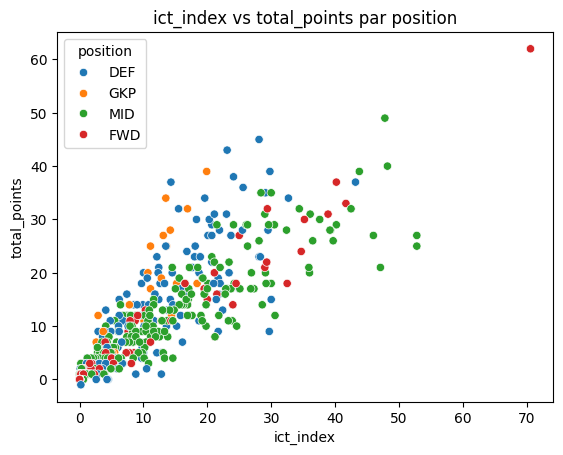

In [16]:
sns.scatterplot(data=df_players, x='ict_index', y='total_points', hue='position')
plt.title('ict_index vs total_points par position')
plt.show()


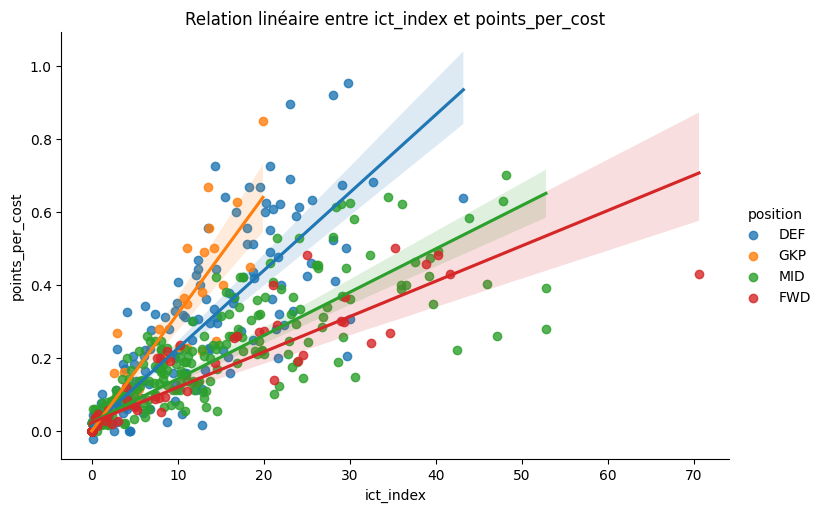

In [17]:
sns.lmplot(data=df_players, x='ict_index', y='points_per_cost', hue='position', aspect=1.5)
plt.title('Relation linéaire entre ict_index et points_per_cost')
plt.show()

In [18]:
import plotly.express as px

fig = px.scatter(
    df_players[df_players['position'] == 'FWD'],  # Filtrer pour éviter les joueurs sans minutes
    x='ict_index',
    y='points_per_cost',
    text='web_name',  # Affiche le nom au survol
    color='position', # Optionnel, couleur par poste
    title='ict_index vs points_per_cost (Hover pour nom du joueur)'
)

fig.update_traces(marker=dict(size=10, opacity=0.7),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.show()

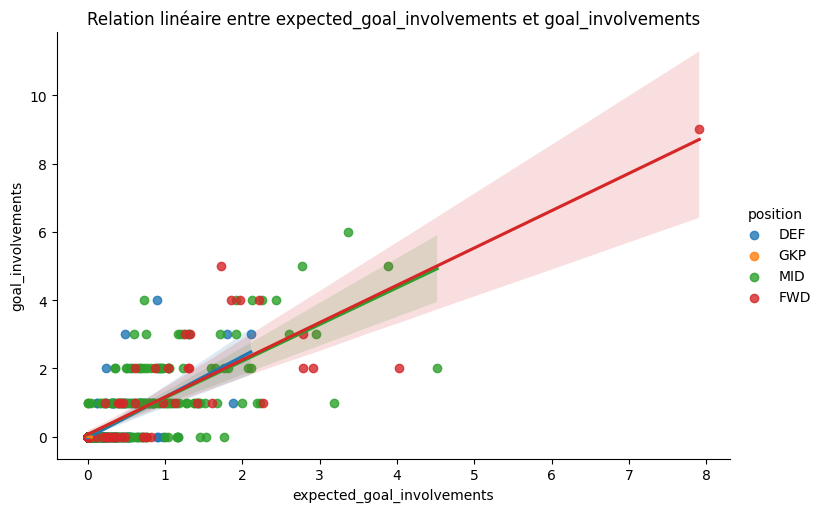

In [19]:
sns.lmplot(data=df_players, x='expected_goal_involvements', y='goal_involvements', hue='position', aspect=1.5)
plt.title('Relation linéaire entre expected_goal_involvements et goal_involvements')
plt.show()


In [20]:
import plotly.express as px

fig = px.scatter(
    df_players,
    x='expected_goal_involvements',
    y='goal_involvements',
    text='web_name',  # Affiche le nom au survol
    color='position', # Optionnel, couleur par poste
    title='Relation linéaire entre expected_goal_involvements et goal_involvements (Hover pour nom du joueur)'
)

fig.update_traces(marker=dict(size=10, opacity=0.7),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.show()